In [ ]:
# !pip install pandas matplotlib seaborn scikit-learn xgboost


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:

import os
import pandas as pd
import numpy as np
from pathlib import Path
import joblib

from typing import Tuple, Dict, Any

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, ParameterGrid, RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR


In [16]:

# Get project root (parent of src)

project_root = Path.cwd().parent
data_path_train = project_root / "data" / "train.csv"
data_path_test = project_root / "data" / "test.csv"

train_df = pd.read_csv(data_path_train)
train_df = train_df.drop(columns=['Id'])

test_df = pd.read_csv(data_path_test)
test_df = test_df.drop(columns=['Id'])


train_df.head()



,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Part 1: Apply all transformation , EDA on Train

Checking the missing % featurewise, and their dtypes

In [17]:
#Checking Missing Columns 
missing = train_df.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_perc = missing / len(train_df)
missing_dtype = missing.sort_values(ascending=False).index.to_series().apply(lambda x: train_df[x].dtype)
missing = pd.concat([missing, missing_perc, missing_dtype], axis=1, keys=['Total', 'Percent', 'Dtype'])
print(missing)

              Total   Percent    Dtype
PoolQC         1453  0.995205   object
MiscFeature    1406  0.963014   object
Alley          1369  0.937671   object
Fence          1179  0.807534   object
MasVnrType      872  0.597260   object
FireplaceQu     690  0.472603   object
LotFrontage     259  0.177397  float64
GarageType       81  0.055479   object
GarageYrBlt      81  0.055479  float64
GarageFinish     81  0.055479   object
GarageQual       81  0.055479   object
GarageCond       81  0.055479   object
BsmtExposure     38  0.026027   object
BsmtFinType2     38  0.026027   object
BsmtQual         37  0.025342   object
BsmtCond         37  0.025342   object
BsmtFinType1     37  0.025342   object
MasVnrArea        8  0.005479  float64
Electrical        1  0.000685   object


In [18]:
# def convert_object_to_category(df: pd.DataFrame) -> pd.DataFrame:
#     df = df.copy()
#     object_cols = df.select_dtypes(include="object").columns
#     df[object_cols] = df[object_cols].astype("category")
#     return df

# ############################## Applying the function ##############################
# train_df = convert_object_to_category(train_df)

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Train and Test Split

In [20]:
def train_test_split_df(df: pd.DataFrame, 
                        target: str, 
                        test_size: float = 0.2, 
                        random_state: int = 42, 
                        stratify: bool = True):
    """
    Split a DataFrame into train and test sets, keeping independent and dependent variables together.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing both features and target.
    target : str
        Name of the target column.
    test_size : float, default=0.2
        Proportion of dataset to include in the test split.
    random_state : int, default=42
        Controls the shuffling applied before the split.
    stratify : bool, default=True
        If True, stratify based on the target column.

    Returns
    -------
    train_df : pd.DataFrame
        Training set with features and target.
    test_df : pd.DataFrame
        Test set with features and target.
    """
    stratify_col = df[target] if stratify else None
    
    train_df, test_df = train_test_split(
        df,
        test_size=test_size,
        random_state=random_state,
        stratify=stratify_col
    )
    
    return train_df, test_df

#################################### Applying the function #########################################

dev, itv = train_test_split_df(train_df, target='SalePrice', test_size=0.2, random_state=42, stratify=False)
print(f"dev set shape: {dev.shape}")
print(f"itv set shape: {itv.shape}")


dev set shape: (1168, 80)
itv set shape: (292, 80)


In [21]:
# numeric_cols= dev.select_dtypes(include=["int64", "float64"]).columns.tolist()
# category_cols = dev.select_dtypes(include="category").columns.tolist()
# object_cols = dev.select_dtypes(include="object").columns.tolist()
# bool_cols = [col for col in category_cols if dev[col].nunique() == 2]

numeric_cols= dev.select_dtypes(include=["int64", "float64"]).columns.tolist()
object_cols = dev.select_dtypes(include="object").columns.tolist()
category_cols = dev.select_dtypes(include="category").columns.tolist()
bool_cols = dev.select_dtypes(include="bool").columns.tolist()


Visualization

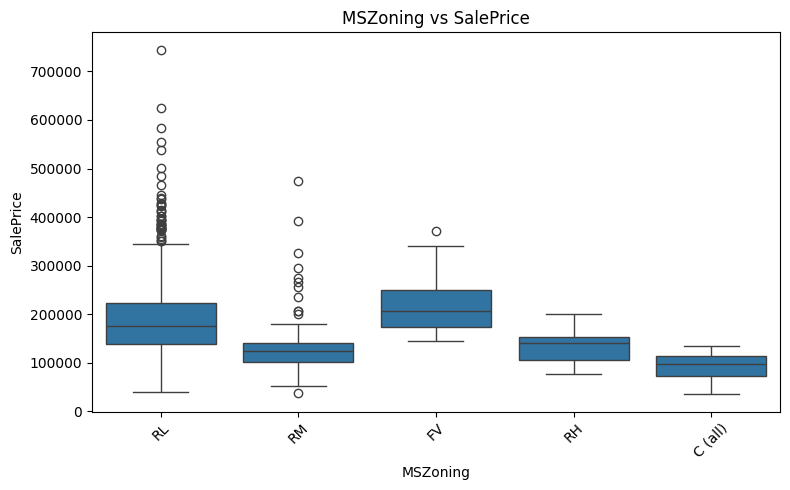

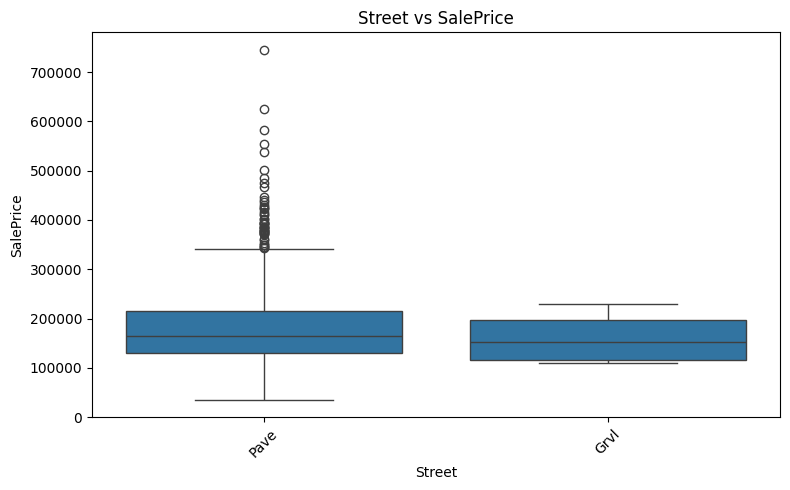

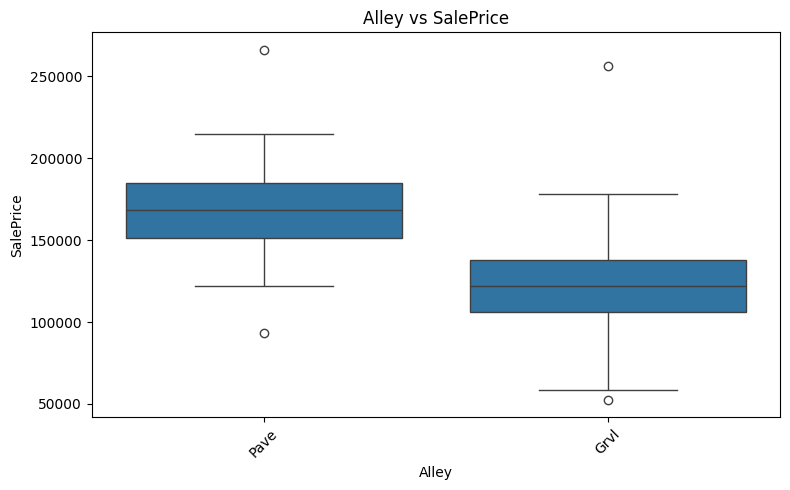

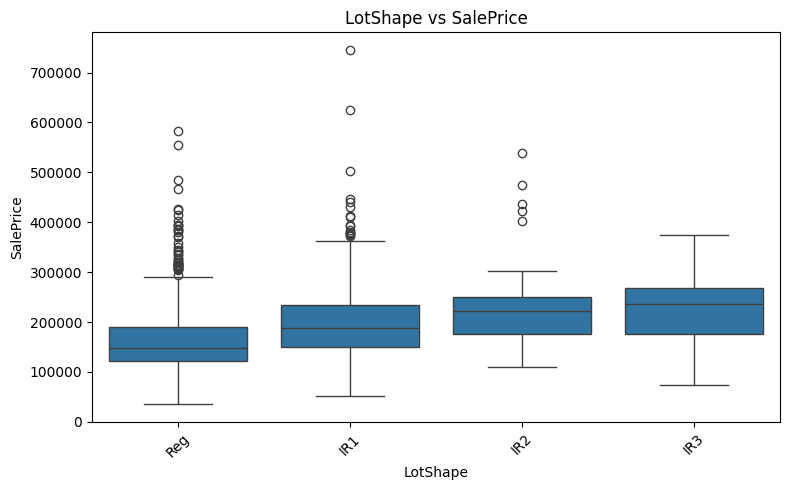

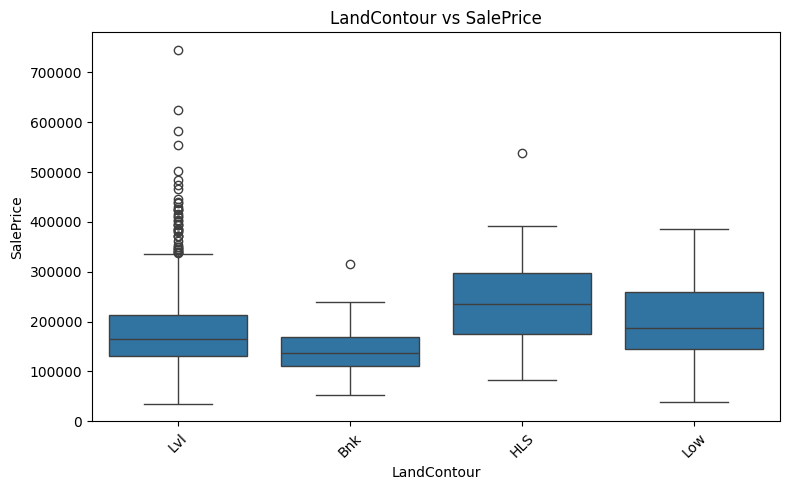

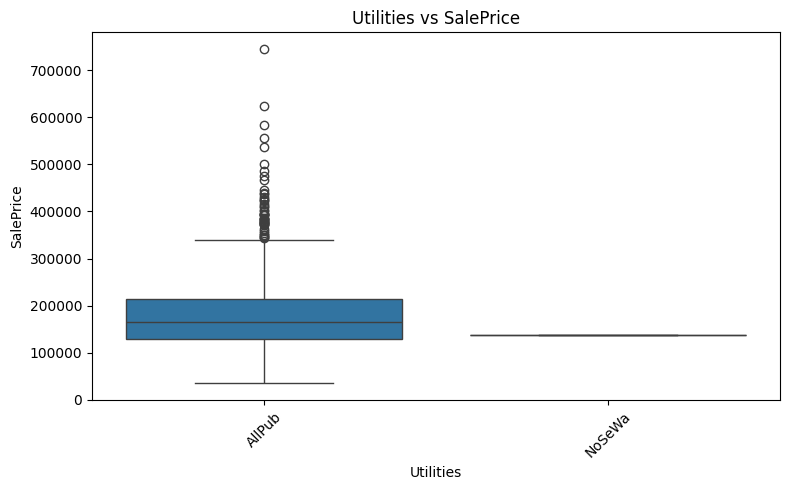

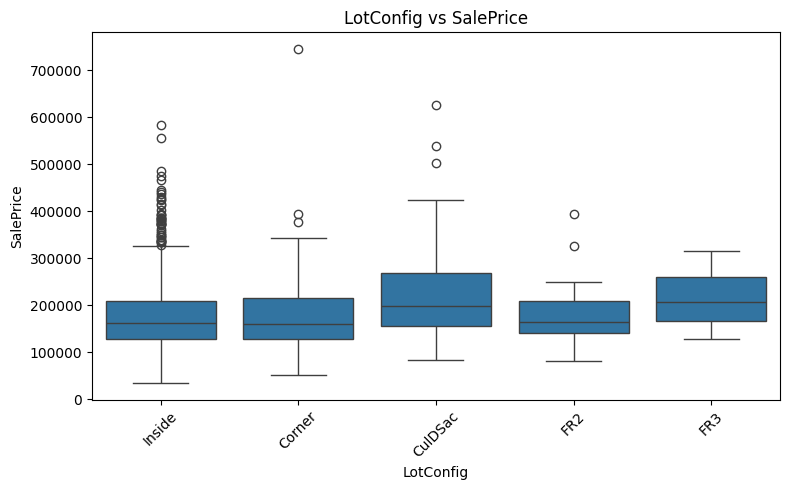

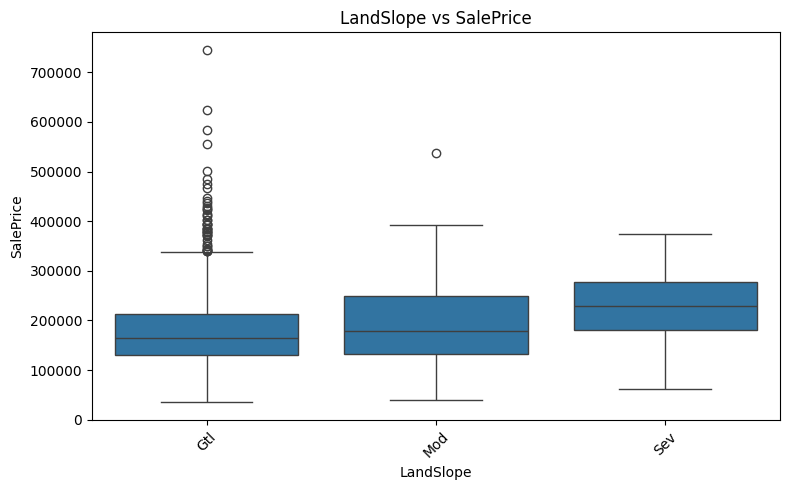

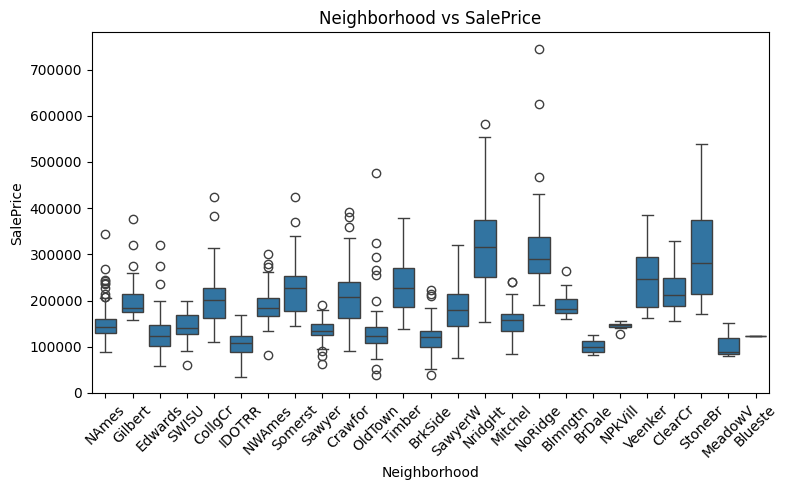

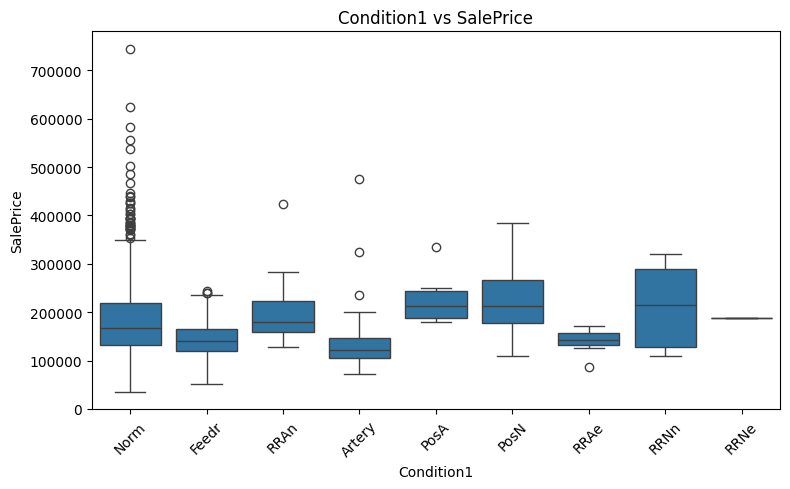

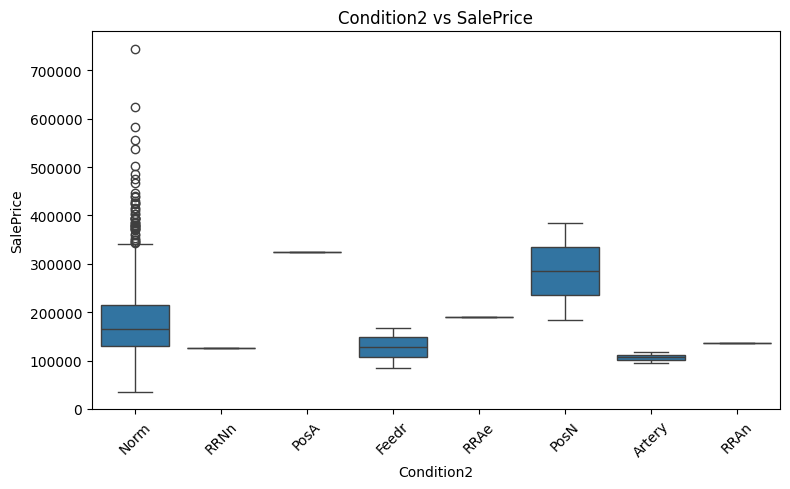

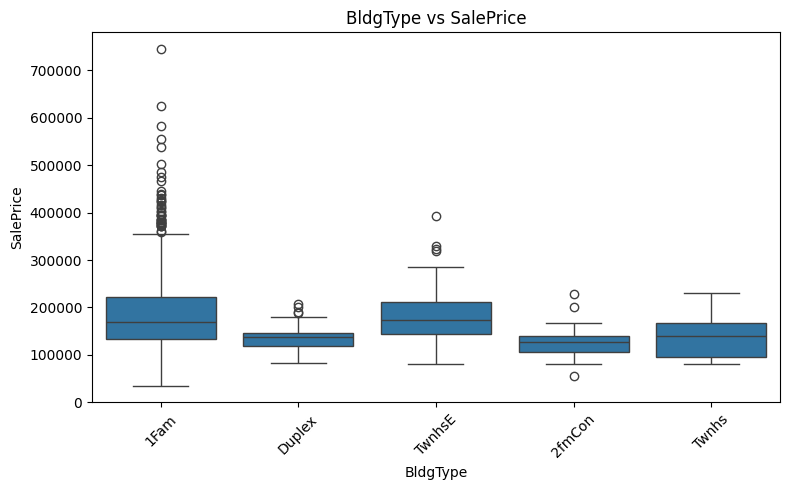

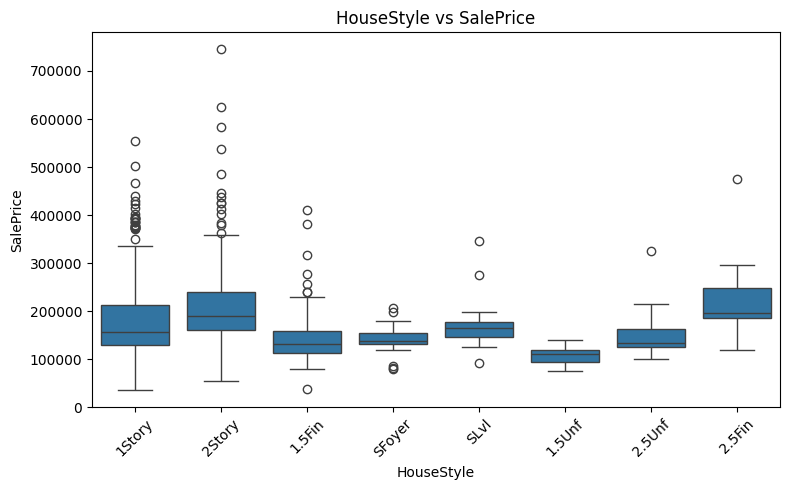

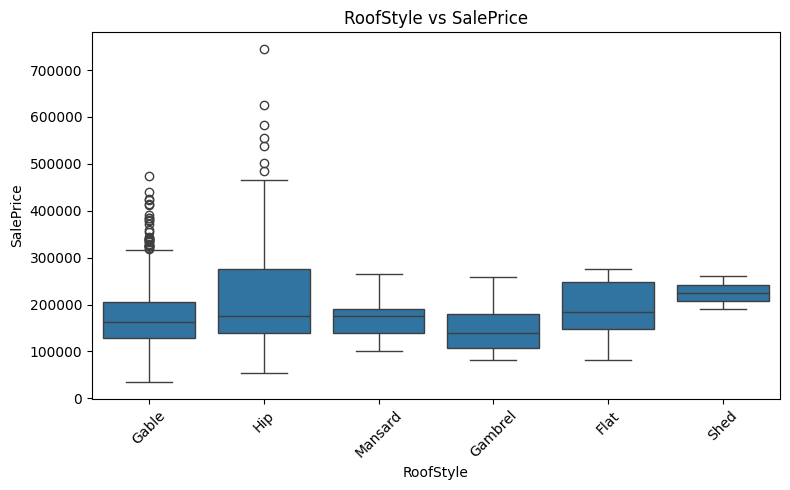

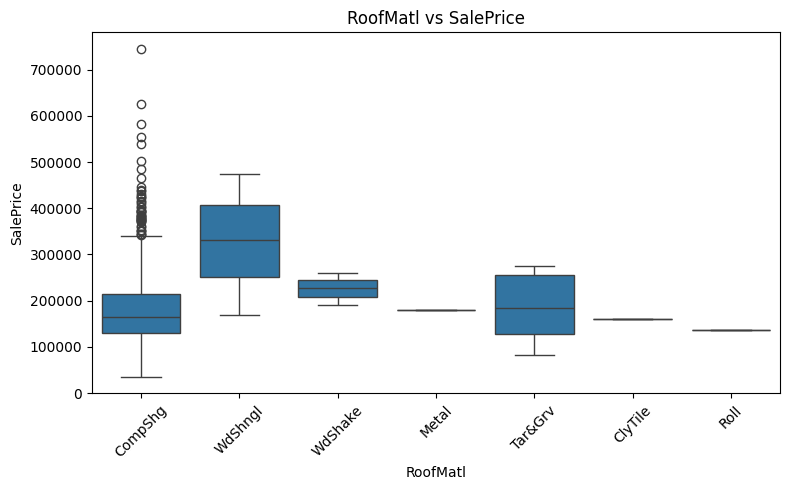

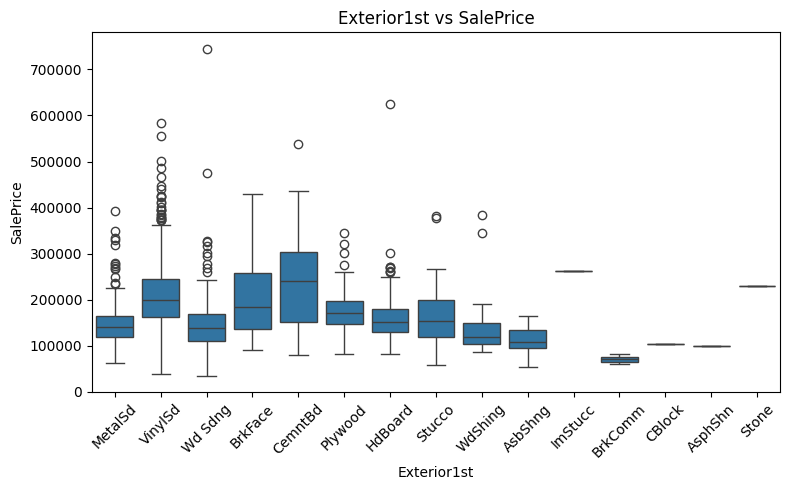

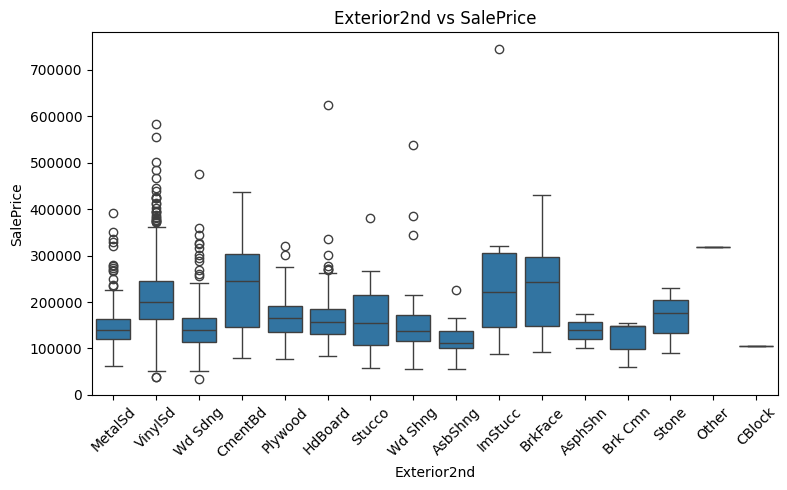

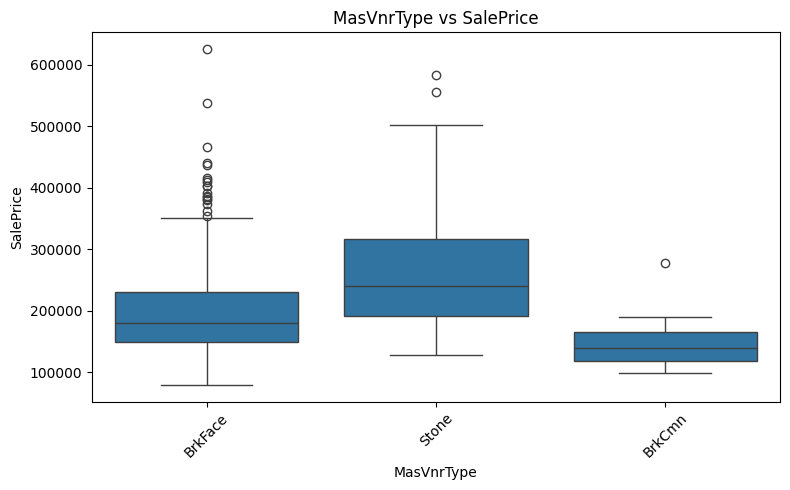

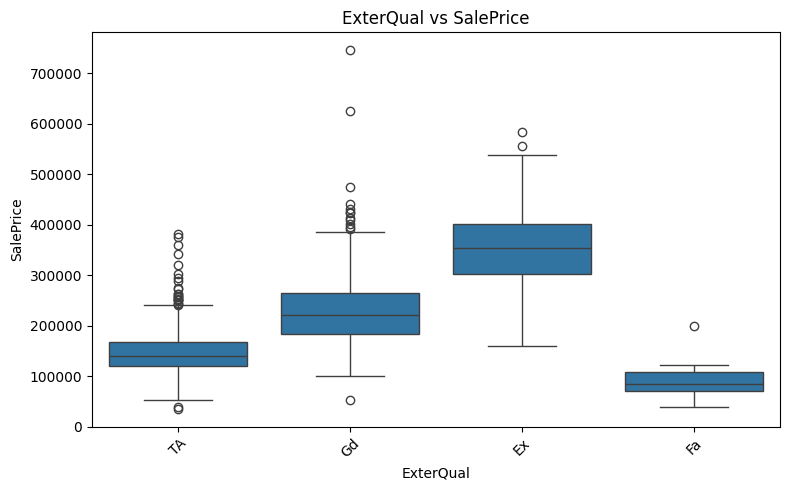

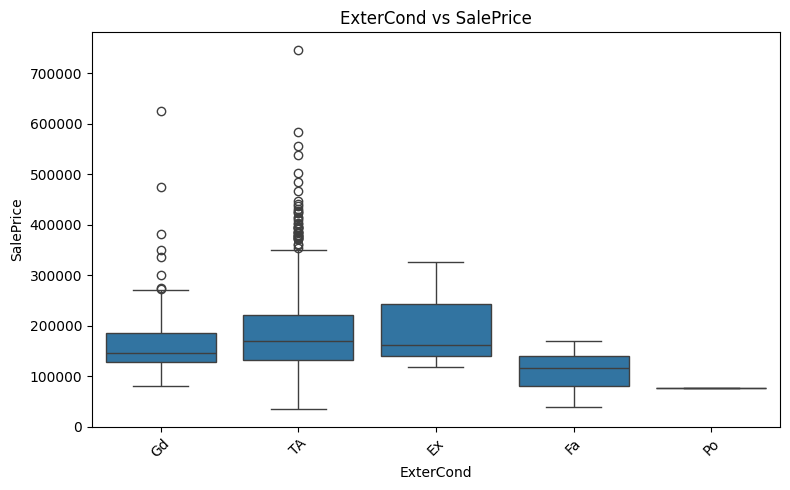

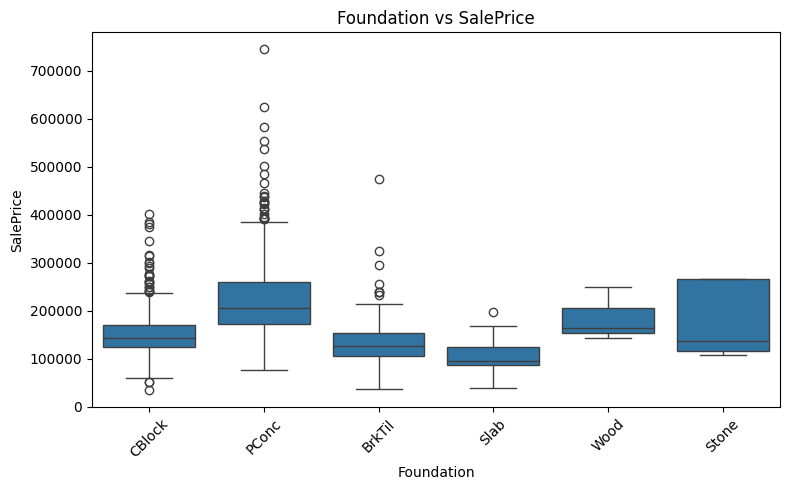

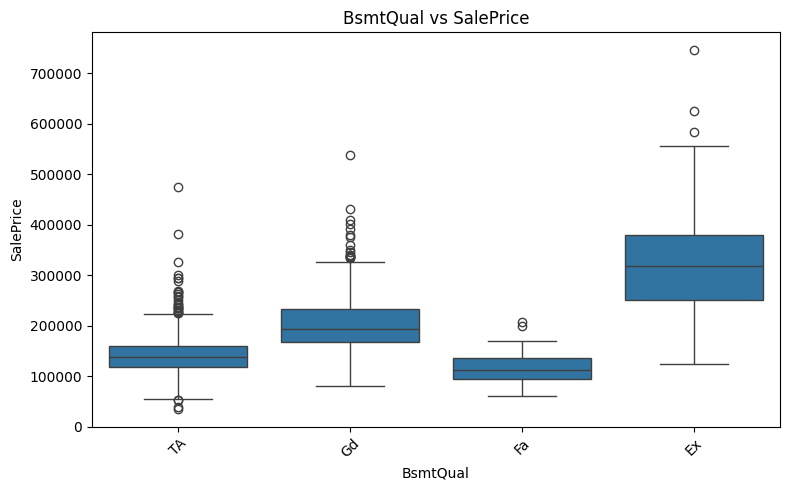

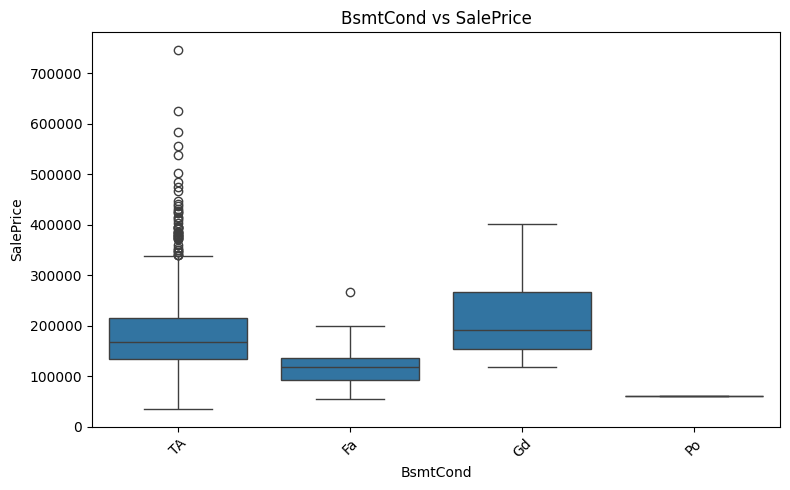

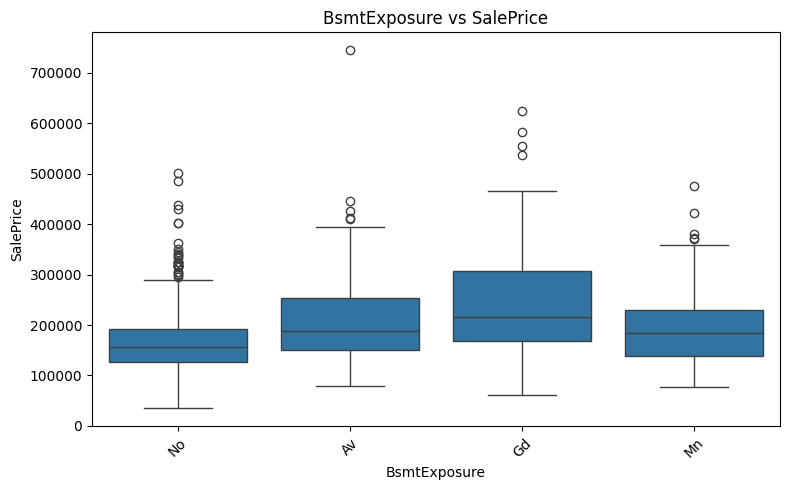

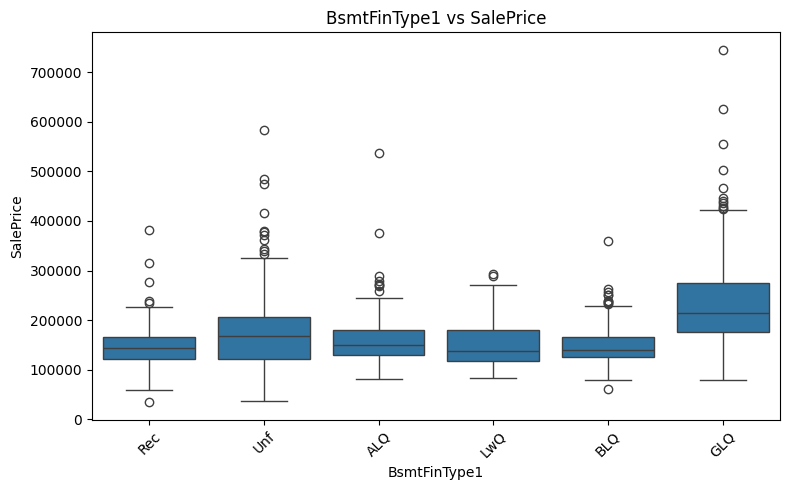

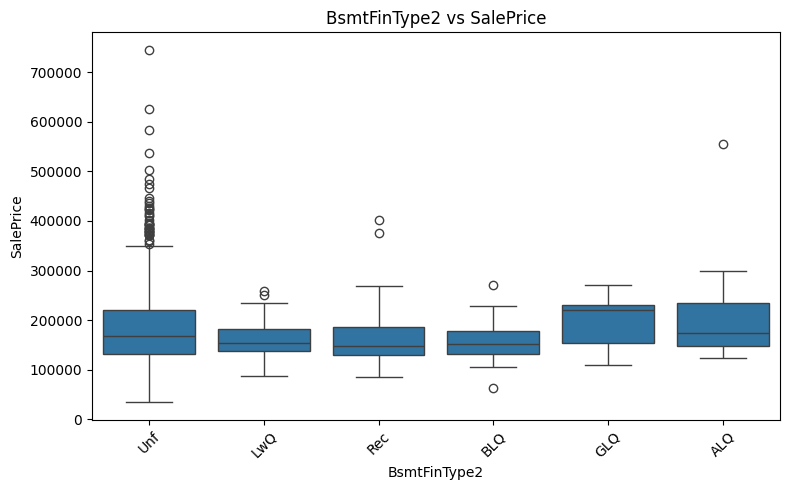

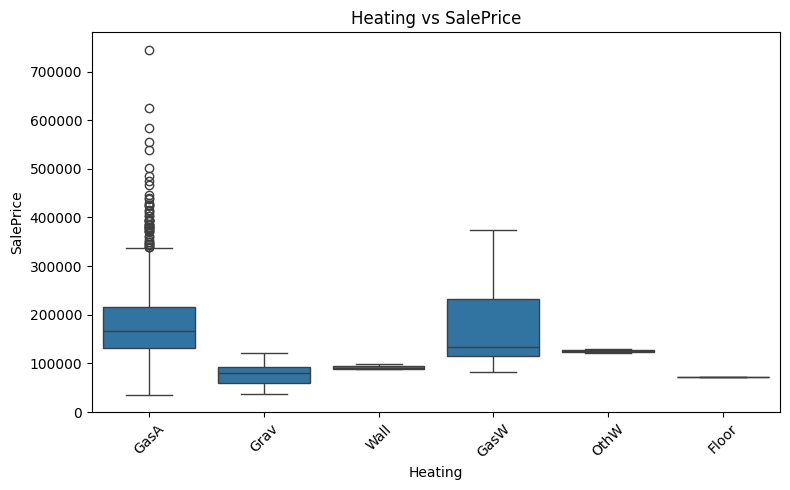

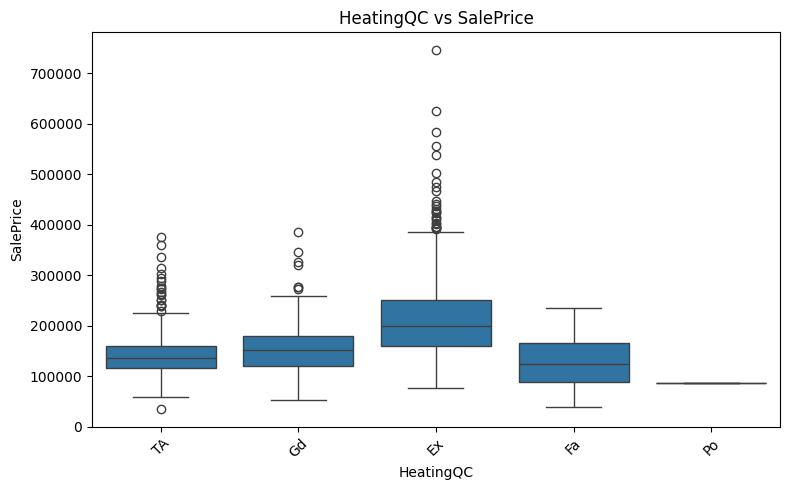

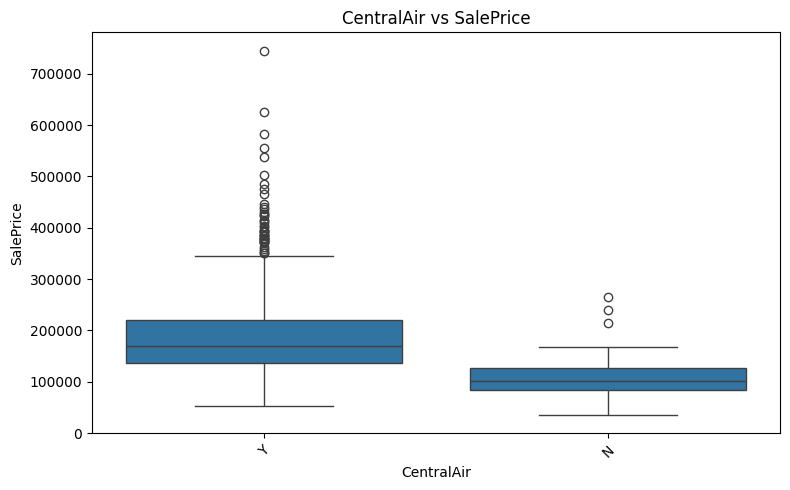

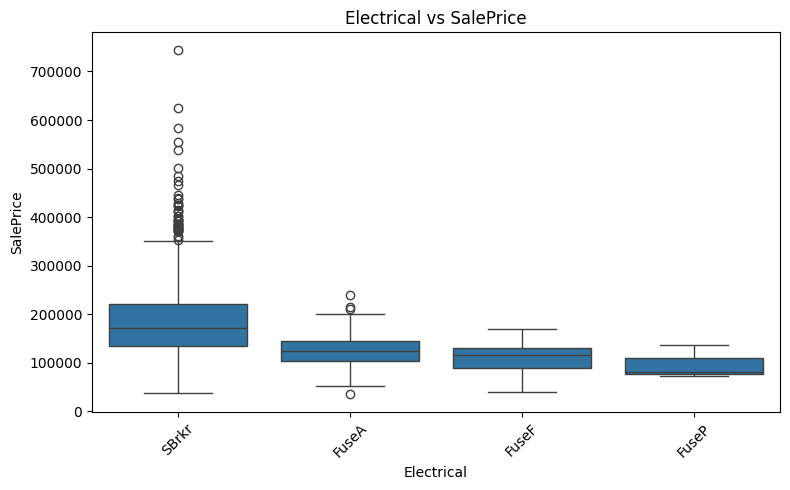

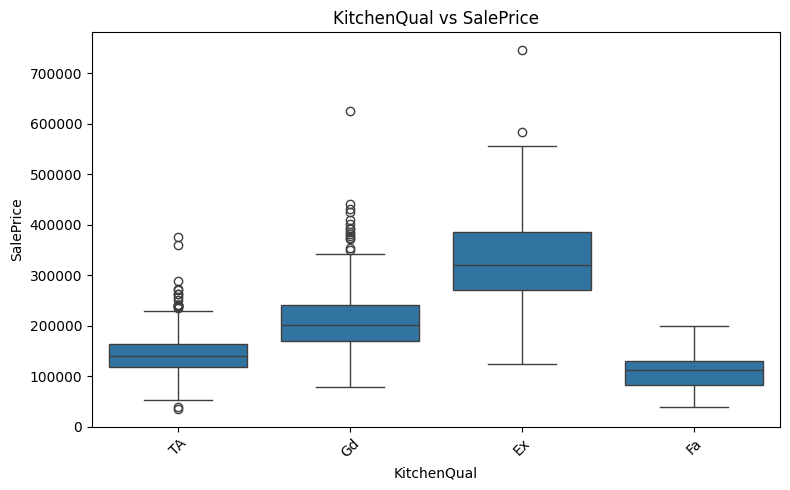

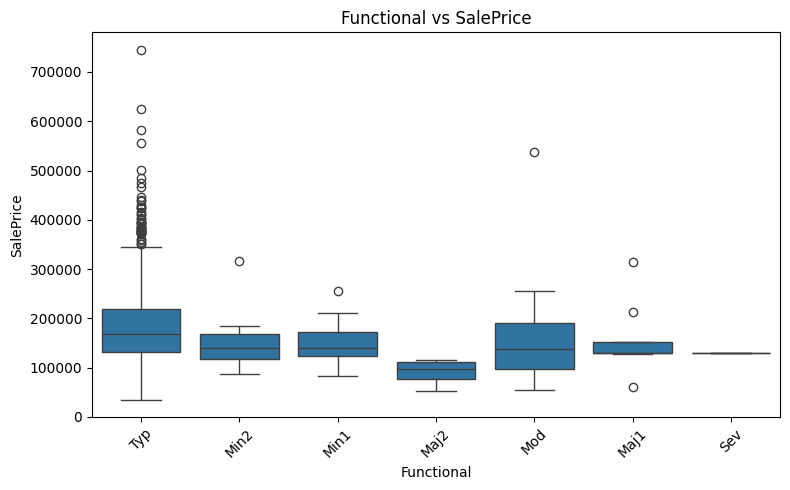

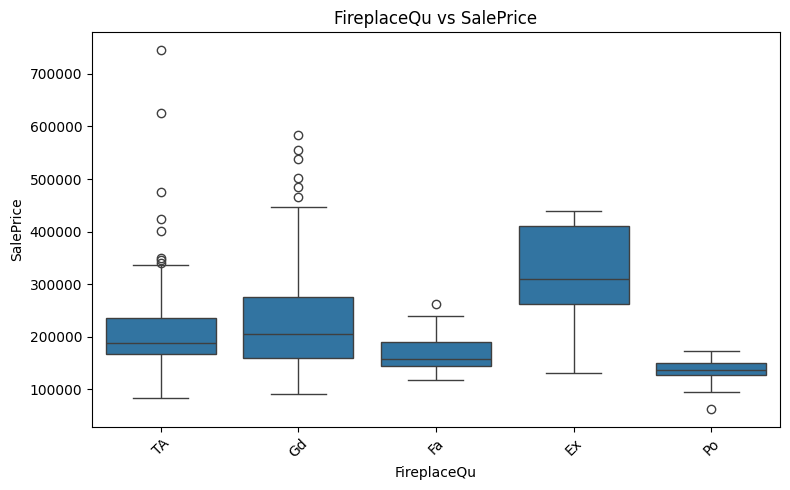

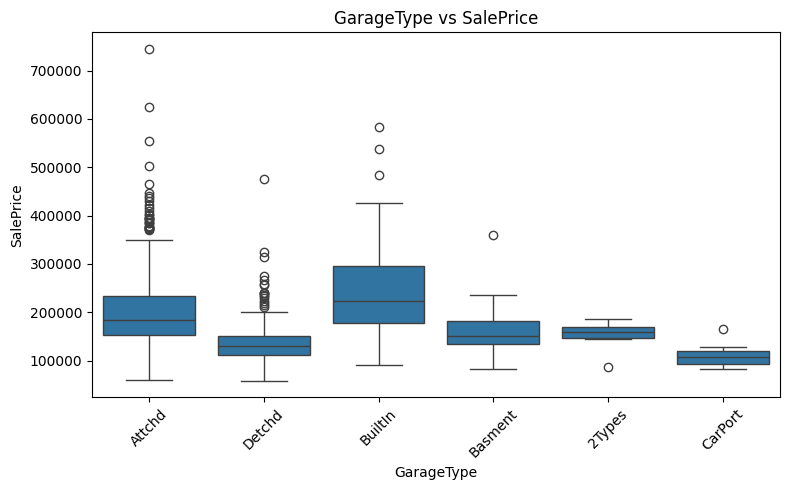

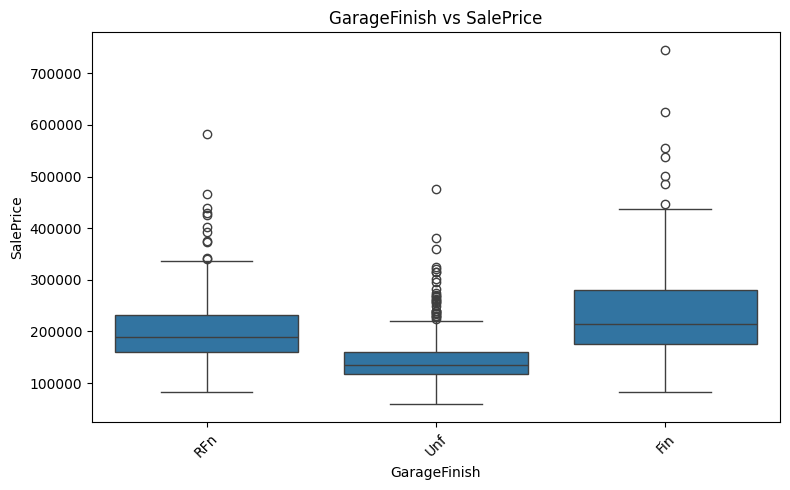

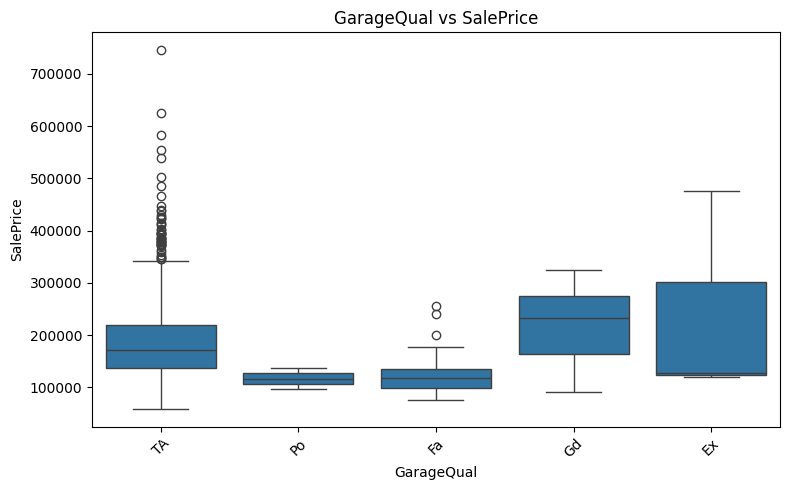

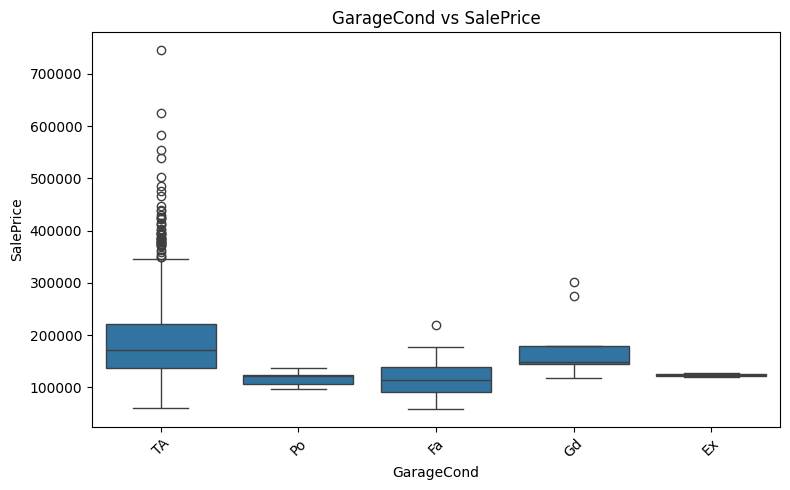

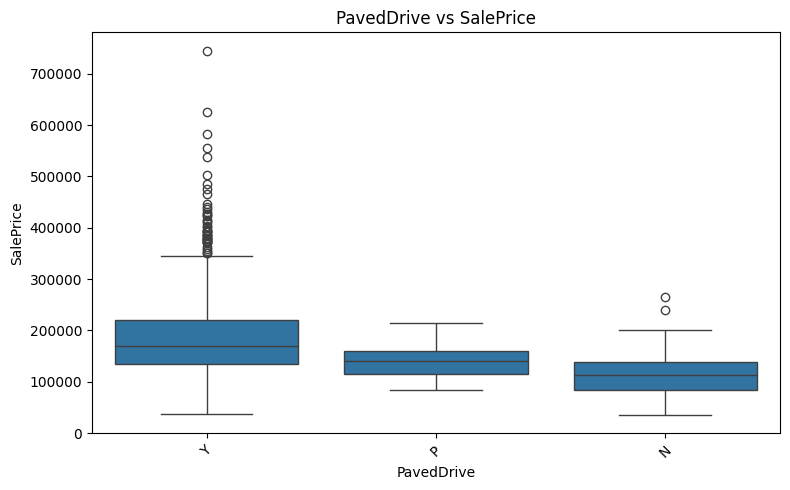

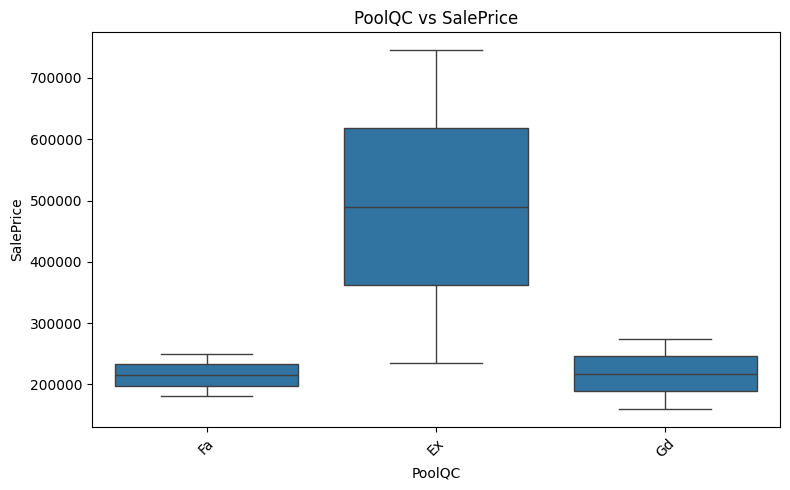

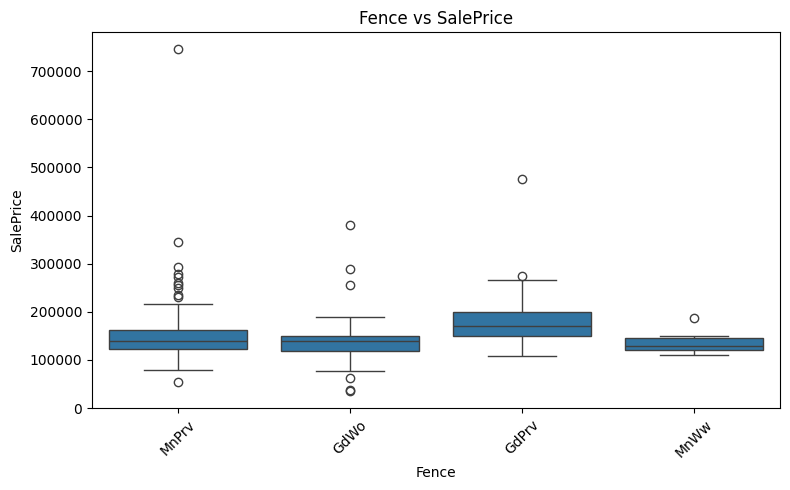

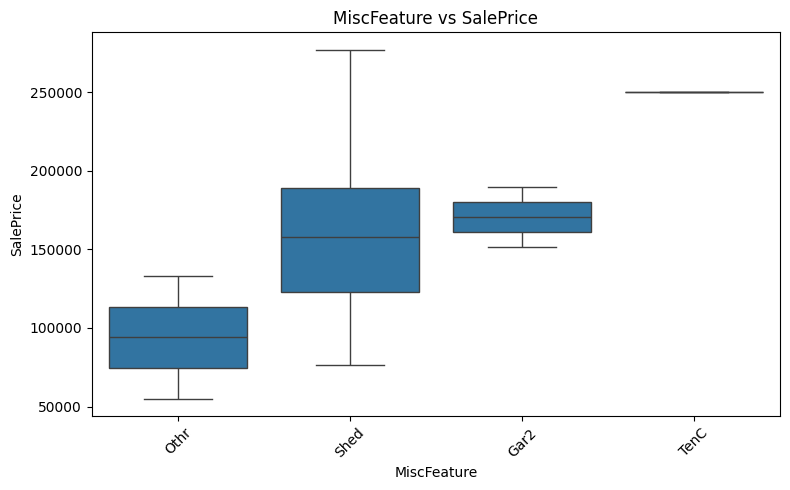

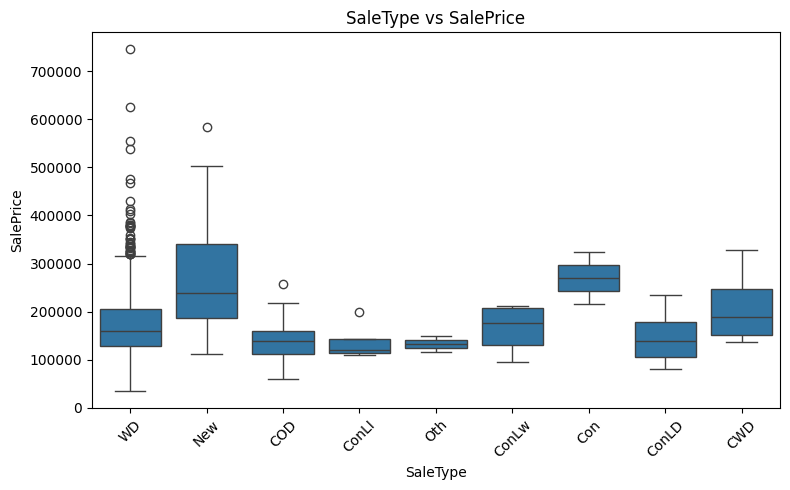

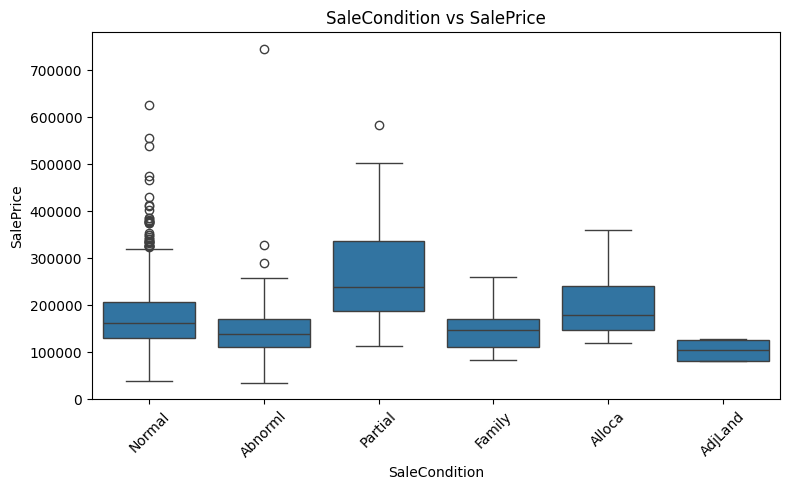

In [22]:
def plot_features_vs_target(df: pd.DataFrame, features: list, target: str, show_corr_heatmap: bool = True):
    """
    Plots distribution/relationship of given features with target variable.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the data
    features (list): List of column names to visualize
    target (str): Target column name (e.g. 'SalePrice')
    show_corr_heatmap (bool): If True, shows correlation heatmap for numeric features
    """
    numeric_feats = []
    
    for col in features:
        plt.figure(figsize=(8, 5))
        
        if df[col].dtype == "category" or df[col].dtype == "object":
            # Categorical / Object variables → boxplot
            sns.boxplot(x=df[col], y=df[target])
            plt.xticks(rotation=45)
            plt.title(f"{col} vs {target}")
        
        else:
            # Numeric variables → scatterplot + correlation
            corr = df[[col, target]].corr().iloc[0, 1]
            numeric_feats.append(col)
            
            sns.scatterplot(x=df[col], y=df[target])
            plt.title(f"{col} vs {target} (corr = {corr:.2f})")
        
        plt.tight_layout()
        plt.show()
    
    # Show correlation heatmap if requested
    if show_corr_heatmap and numeric_feats:
        corr_matrix = df[numeric_feats + [target]].corr()
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
        plt.title("Correlation Heatmap with Target")
        plt.show()

############################# Applying the fucntion on train_df ##############################
# plot_features_vs_target(dev, numeric_cols, "SalePrice")
plot_features_vs_target(dev, object_cols, "SalePrice")

# sns.pairplot(dev_imputed[["SalePrice"] + ["GrLivArea", "TotalBsmtSF"]], diag_kind="kde", corner=False)



Feature Engineering

In [23]:
def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # ---- Age-related features ----
    df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
    df["RemodAge"] = df["YrSold"] - df["YearRemodAdd"]

    # ---- Was remodeled or not ----
    df["IsRemodeled"] = (df["YearBuilt"] != df["YearRemodAdd"]).astype(int)

    # ---- Time since remodel vs build ----
    df["SinceRemodelVsBuild"] = df["YearRemodAdd"] - df["YearBuilt"]

    # ---- House age bins ----
    df["HouseAgeBin"] = pd.cut(
        df["HouseAge"],
        bins=[-1, 10, 30, 60, 100, 200],  # -1 handles 0 properly
        labels=["New", "Recent", "Mid", "Old", "VeryOld"]
    )

    # ---- Seasonality of sale ----
    df["SaleSeason"] = df["MoSold"].map({
        12: "Winter", 1: "Winter", 2: "Winter",
        3: "Spring", 4: "Spring", 5: "Spring",
        6: "Summer", 7: "Summer", 8: "Summer",
        9: "Fall", 10: "Fall", 11: "Fall"
    })

    # ---- Interaction features ----
    if "OverallQual" in df.columns:
        df["AgeQualInteraction"] = df["HouseAge"] * df["OverallQual"]

    if "OverallCond" in df.columns:
        df["RemodCondInteraction"] = df["RemodAge"] * df["OverallCond"]

    # if "OverallQual" in df.columns:
    #     df["RemodQualBoost"] = df["IsRemodeled"] * df["OverallQual"]

    # ---- Drop raw year variables ----
    df = df.drop(columns=["YearBuilt", "YearRemodAdd", "YrSold"], errors="ignore")

    return df


############################## Applying the function ##############################
dev_fe = add_time_features(dev)
itv_fe = add_time_features(itv)
print(f"dev_fe shape added time features: {dev_fe.shape}")
print(f"itv_fe shape added time features: {itv_fe.shape}")


dev_fe shape added time features: (1168, 85)
itv_fe shape added time features: (292, 85)


In [24]:
def add_numeric_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # ---- 1. Total Bathrooms ----
    df["TotalBathrooms"] = (
        df["FullBath"] + (0.5 * df["HalfBath"]) +
        df["BsmtFullBath"] + (0.5 * df["BsmtHalfBath"])
    )

    # ---- 2. Total Porch SF ----
    df["TotalPorchSF"] = (
        df["WoodDeckSF"] + df["OpenPorchSF"] +
        df["EnclosedPorch"] + df["3SsnPorch"] +
        df["ScreenPorch"]
    )

    # ---- 3. Total House SF (basement + 1st + 2nd floor) ----
    df["TotalHouseSF"] = (
        df["1stFlrSF"] + df["2ndFlrSF"] + df["TotalBsmtSF"]
    )

    # ---- 4. Total Finished SF (above grade + finished basement) ----
    df["TotalFinishedSF"] = (
        df["GrLivArea"] + df["BsmtFinSF1"] + df["BsmtFinSF2"]
    )

    # ---- 5. Total Rooms (above grade + bedrooms + kitchens) ----
    df["TotalRooms"] = (
        df["TotRmsAbvGrd"] + df["BedroomAbvGr"] + df["KitchenAbvGr"]
    )

    # ---- 6. Baths per Bedroom ----
    df["BathsPerBedroom"] = df["TotalBathrooms"] / (df["BedroomAbvGr"] + 1)

    # ---- 7. Living Area per Room ----
    df["LivingAreaPerRoom"] = df["GrLivArea"] / (df["TotRmsAbvGrd"] + 1)

    # ---- 8. Garage Score (cars * area) ----
    df["GarageScore"] = df["GarageCars"] * df["GarageArea"]

    # ---- 9. Lot Area per House SF ----
    df["LotAreaPerSF"] = df["LotArea"] / (df["TotalHouseSF"] + 1)

    # ---- 10. Basement Ratio (finished / total) ----
    df["BasementRatio"] = (
        (df["BsmtFinSF1"] + df["BsmtFinSF2"]) / (df["TotalBsmtSF"] + 1)
    )

    return df

############################## Applying the function ##############################
dev_fe = add_numeric_features(dev_fe)  
itv_fe = add_numeric_features(itv_fe)
print(f"dev_fe shape added time plus numeric features: {dev_fe.shape}")
print(f"itv_fe shape added time plus numeric features: {itv_fe.shape}")


dev_fe shape added time plus numeric features: (1168, 95)
itv_fe shape added time plus numeric features: (292, 95)


Creating a function to impute the missing values by their data types

In [25]:
def impute_missing(
    df: pd.DataFrame,
    object_cols: list[str],
    numeric_cols: list[str],
    category_cols: list[str],
    bool_cols: list[str]
) -> Tuple[pd.DataFrame, Dict[str, object]]:
    """
    Imputes missing values in a DataFrame:
    - Object columns      -> 'Not available'
    - Categorical columns -> add category 'Not available'
    - Boolean columns     -> False
    - Numeric columns     -> median

    Returns:
        df_copy (pd.DataFrame): Imputed dataframe
        imputers (dict): Dictionary of imputers/strategies for later use
    """
    df_copy = df.copy()
    imputers = {}

    # 1. Object columns -> fillna("Not available")
    df_copy[object_cols] = df_copy[object_cols].fillna("Not available")
    imputers["object"] = {"strategy": "fillna", "value": "Not available"}

    # 2. Category columns -> add "Not available" category then fill
    if category_cols:
        for col in category_cols:
            if "Not available" not in df_copy[col].cat.categories:
                df_copy[col] = df_copy[col].cat.add_categories("Not available")
            df_copy[col] = df_copy[col].fillna("Not available")
        imputers["category"] = {"strategy": "add_category+fillna", "value": "Not available"}

    # 3. Boolean columns -> fillna(False)
    if bool_cols:
        df_copy[bool_cols] = df_copy[bool_cols].fillna(False)
        imputers["bool"] = {"strategy": "fillna", "value": False}

    # 4. Numeric columns -> median imputer
    num_imputer = SimpleImputer(strategy="median")
    df_copy[numeric_cols] = num_imputer.fit_transform(df_copy[numeric_cols])
    imputers["numeric"] = num_imputer

    return df_copy, imputers


#################################### Applying the function #########################################

######################################### dev ######################################################

# Apply imputation
dev_imputed, imputers = impute_missing(dev_fe, 
                                       object_cols,
                                       list(set(numeric_cols) - set(["YearBuilt","YearRemodAdd","YrSold"])), 
                                        category_cols,
                                          bool_cols)

print(dev_imputed.isnull().sum().sum())  # should be 0
print(imputers)  # see what imputers/strategies are stored
print(f"dev_imputed shape: {dev_imputed.shape}")


0
{'object': {'strategy': 'fillna', 'value': 'Not available'}, 'numeric': SimpleImputer(strategy='median')}
dev_imputed shape: (1168, 95)


Creating function which will apply the imputed object on itv

In [26]:
def apply_imputers(
    df: pd.DataFrame,
    imputers: dict,
    numeric_cols: list,
    object_cols: list,
    category_cols: list,
    bool_cols: list
) -> pd.DataFrame:
    """
    Apply imputers to a dataframe and return an imputed copy.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset to apply imputations on (e.g., test set).
    imputers : dict
        Dictionary of imputers/values for different data types.
    numeric_cols : list
        List of numeric columns.
    object_cols : list
        List of object/text columns.
    category_cols : list
        List of categorical columns.
    bool_cols : list
        List of boolean columns.

    Returns
    -------
    df_imputed : pd.DataFrame
        New dataframe with imputations applied.
    """
    df_imputed = df.copy()

    # Numeric
    if numeric_cols:
        df_imputed[numeric_cols] = imputers["numeric"].transform(df_imputed[numeric_cols])

    # Object
    if object_cols:
        df_imputed[object_cols] = df_imputed[object_cols].fillna(imputers["object"]["value"])

    # Category
    for col in category_cols:
        if "Not available" not in df_imputed[col].cat.categories:
            df_imputed[col] = df_imputed[col].cat.add_categories("Not available")
        df_imputed[col] = df_imputed[col].fillna("Not available")

    # Boolean
    if bool_cols:
        df_imputed[bool_cols] = df_imputed[bool_cols].fillna(imputers["bool"]["value"])

    return df_imputed

#################################### Applying the function #########################################

########################################## itv ######################################################
itv_imputed = apply_imputers(itv_fe, 
                             imputers, 
                             list(set(numeric_cols) - set(["YearBuilt","YearRemodAdd","YrSold"])), 
                             object_cols, 
                             category_cols, 
                             bool_cols)
print(itv_imputed.isnull().sum().sum())  # should be 0
print(imputers)  # see what imputers/strategies are stored
print(f"itv_imputed shape: {itv_imputed.shape}")


0
{'object': {'strategy': 'fillna', 'value': 'Not available'}, 'numeric': SimpleImputer(strategy='median')}
itv_imputed shape: (292, 95)


Encoding by Feature Types ( this step required understanding of the data and manually looking into it)

In [27]:
def preprocess_encoding_fit(
    df: pd.DataFrame,
    target: str,
    cutoff: int = 10
) -> pd.DataFrame:
    df = df.copy()

    # ---------- Ordinal numeric ----------
    ordinal_numeric = ["OverallQual", "OverallCond"]

    # ---------- Object but ordinal category ----------
    ordinal_maps = {
        "ExterQual": {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1},
        "ExterCond": {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1},
        "BsmtQual": {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1,"NA":0},
        "BsmtCond": {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1,"NA":0},
        "BsmtExposure": {"Gd":4,"Av":3,"Mn":2,"No":1,"NA":0},
        "BsmtFinType1": {"GLQ":6,"ALQ":5,"BLQ":4,"Rec":3,"LwQ":2,"Unf":1,"NA":0},
        "BsmtFinType2": {"GLQ":6,"ALQ":5,"BLQ":4,"Rec":3,"LwQ":2,"Unf":1,"NA":0},
        "HeatingQC": {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1},
        "KitchenQual": {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1},
        "FireplaceQu": {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1,"NA":0},
        "GarageQual": {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1,"NA":0},
        "GarageCond": {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1,"NA":0},
        "GarageFinish": {"Fin":3,"RFn":2,"Unf":1,"NA":0},
        "PoolQC": {"Ex":4,"Gd":3,"TA":2,"Fa":1,"NA":0},
        "Fence": {"GdPrv":4,"MnPrv":3,"GdWo":2,"MnWw":1,"NA":0},
        "Functional": {"Typ":7,"Min1":6,"Min2":5,"Mod":4,"Maj1":3,"Maj2":2,"Sev":1,"Sal":0},
        "PavedDrive": {"Y":2,"P":1,"N":0}
    }

    var_type_records = []  # store variable classification

    # Apply ordinal mappings
    for col, mapping in ordinal_maps.items():
        if col in df.columns:
            df[col] = df[col].map(mapping)
            var_type_records.append({"variable": col, "type": "ordinal_categorical"})

    for col in ordinal_numeric:
        if col in df.columns:
            var_type_records.append({"variable": col, "type": "ordinal_numeric"})

    # ---------- Case 1: Numeric but categorical ----------
    if "MSSubClass" in df.columns:
        df["MSSubClass"] = df["MSSubClass"].astype("object")
        var_type_records.append({"variable": "MSSubClass", "type": "categorical_numeric"})

    # ---------- Case 2: Numeric with low variation ----------
    low_var_cols = [
        col for col in df.select_dtypes(include="number").columns
        if col not in [target] + ordinal_numeric and df[col].nunique() < 3
    ]
    for col in low_var_cols:
        df[col] = df[col].astype("object")
        var_type_records.append({"variable": col, "type": "categorical_numeric"})

    # ---------- Case 3: Object but no order ----------
    nominal_cols = df.select_dtypes(include="object").columns

    encoding_records = []
    onehot_cols = []
    target_encoded_cols = []
    global_mean = df[target].mean()

    for col in nominal_cols:
        if df[col].nunique() <= cutoff:
            dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
            df = pd.concat([df.drop(columns=[col]), dummies], axis=1)
            onehot_cols.extend(dummies.columns.tolist())
                
            # tag the newly created dummy columns, not the dropped one
            for dcol in dummies.columns:
                var_type_records.append({"variable": dcol, "type": "nominal_categorical"})
        else:
            target_mean = df.groupby(col)[target].mean()
            temp = target_mean.reset_index()
            temp.columns = ["Category", "AverageSalePrice"]
            temp.insert(0, "Variable", col)
            encoding_records.append(temp)
            df[col] = df[col].map(target_mean).fillna(global_mean)
            target_encoded_cols.append(col)
            var_type_records.append({"variable": col, "type": "target_encoded"})

    # ---------- Final sweep: assign pure numeric ----------
    tagged_vars = {rec["variable"] for rec in var_type_records}
    for col in df.columns:
        if col not in tagged_vars and col != target:
            if pd.api.types.is_numeric_dtype(df[col]):
                var_type_records.append({"variable": col, "type": "continuous_numeric"})

    # ---------- Save artifacts ----------
    artifacts_dir = project_root / "artifacts"
    os.makedirs(artifacts_dir, exist_ok=True)

    if encoding_records:
        encoding_df = pd.concat(encoding_records, ignore_index=True)
        encoding_df.to_csv(artifacts_dir / "target_mean_encoding.csv", index=False)

    pd.Series(onehot_cols).to_csv(artifacts_dir / "onehot_columns.csv", index=False)
    pd.Series([global_mean]).to_csv(artifacts_dir / "global_mean.csv", index=False)
    pd.Series(df.columns).to_csv(artifacts_dir / "feature_columns.csv", index=False)

    var_type_df = pd.DataFrame(var_type_records)
    var_type_df.to_csv(artifacts_dir / "variable_types.csv", index=False)

    return df

#################################### Applying the function #########################################
dev_encoded = preprocess_encoding_fit(dev_imputed, target="SalePrice", cutoff=5)
print(f"dev encoded shape: {dev_encoded.shape}")


dev encoded shape: (1168, 120)


Applying the encoding logic on itv

In [28]:
def preprocess_encoding_fit_transform(df: pd.DataFrame, cutoff: int = 10) -> pd.DataFrame:
    df = df.copy()

    # load encodings
    encoding_df = pd.read_csv(project_root / "artifacts" / "target_mean_encoding.csv")
    onehot_cols = pd.read_csv(project_root / "artifacts" / "onehot_columns.csv")
    global_mean = pd.read_csv(project_root / "artifacts" / "global_mean.csv")
    final_features = pd.read_csv(project_root / "artifacts" / "feature_columns.csv")

    onehot_cols = onehot_cols.iloc[:,0].tolist()
    global_mean = global_mean.iloc[0,0]
    final_features = final_features.iloc[:,0].tolist()

    # ---------- Object but ordinal category ----------
    ordinal_maps = {
        "ExterQual": {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1},
        "ExterCond": {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1},
        "BsmtQual": {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1,"NA":0},
        "BsmtCond": {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1,"NA":0},
        "BsmtExposure": {"Gd":4,"Av":3,"Mn":2,"No":1,"NA":0},
        "BsmtFinType1": {"GLQ":6,"ALQ":5,"BLQ":4,"Rec":3,"LwQ":2,"Unf":1,"NA":0},
        "BsmtFinType2": {"GLQ":6,"ALQ":5,"BLQ":4,"Rec":3,"LwQ":2,"Unf":1,"NA":0},
        "HeatingQC": {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1},
        "KitchenQual": {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1},
        "FireplaceQu": {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1,"NA":0},
        "GarageQual": {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1,"NA":0},
        "GarageCond": {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1,"NA":0},
        "GarageFinish": {"Fin":3,"RFn":2,"Unf":1,"NA":0},
        "PoolQC": {"Ex":4,"Gd":3,"TA":2,"Fa":1,"NA":0},
        "Fence": {"GdPrv":4,"MnPrv":3,"GdWo":2,"MnWw":1,"NA":0},
        "Functional": {"Typ":7,"Min1":6,"Min2":5,"Mod":4,"Maj1":3,"Maj2":2,"Sev":1,"Sal":0},
        "PavedDrive": {"Y":2,"P":1,"N":0}
    }
    for col, mapping in ordinal_maps.items():
        if col in df.columns:
            df[col] = df[col].map(mapping)

    if "MSSubClass" in df.columns:
        df["MSSubClass"] = df["MSSubClass"].astype("object")

    # target encodings
    for variable in encoding_df["Variable"].unique():
        mapping = encoding_df[encoding_df["Variable"] == variable] \
                    .set_index("Category")["AverageSalePrice"].to_dict()
        if variable in df.columns:
            df[variable] = df[variable].map(mapping).fillna(global_mean)

    # one-hot encoding alignment
    current_nominals = df.select_dtypes(include="object").columns
    for col in current_nominals:
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df = pd.concat([df.drop(columns=[col]), dummies], axis=1)

    for col in onehot_cols:
        if col not in df.columns:
            df[col] = 0  # add missing dummy column

    # align final feature order
    df = df.reindex(columns=final_features, fill_value=0)

    return df

################################### Applying the function #########################################
itv_encoded = preprocess_encoding_fit_transform(itv_imputed, cutoff=5)
print(f"itv encoded shape: {itv_encoded.shape}")



itv encoded shape: (292, 120)


Flooring and Capping Numeric Variables (Create summary based on dev, take p1 , p99 and apply the same to itv)

In [16]:
def describe_numeric_summary(
    dev: pd.DataFrame,
    variable_types_path= project_root / "artifacts" / "variable_types.csv",
    save_path= project_root / "artifacts" / "numeric_summary.csv"
) -> pd.DataFrame:
    """
    Generate descriptive statistics for continuous numeric variables in the dev dataset.
    Loads variable type assignments from `variable_types.csv` instead of only relying on dtype.
    Saves summary as CSV.
    """
    # Load variable types
    var_types = pd.read_csv(variable_types_path)
    print(var_types.shape)

    # Filter only continuous numeric
    cont_vars = var_types.loc[var_types["type"] == "continuous_numeric", "variable"].tolist()
    print(len(cont_vars))

    summary = []
    for col in cont_vars:
        if col in dev.columns:  # safeguard in case some dropped
            stats = {
                "variable": col,
                "mean": dev[col].mean(),
                "std": dev[col].std(),
                "p1": np.percentile(dev[col].dropna(), 1),
                "p10": np.percentile(dev[col].dropna(), 10),
                "p25": np.percentile(dev[col].dropna(), 25),
                "p50": np.percentile(dev[col].dropna(), 50),
                "p75": np.percentile(dev[col].dropna(), 75),
                "p90": np.percentile(dev[col].dropna(), 90),
                "p95": np.percentile(dev[col].dropna(), 95),
                "p99": np.percentile(dev[col].dropna(), 99),
            }
            summary.append(stats)

    summary_df = pd.DataFrame(summary)

    # Ensure artifacts directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    summary_df.to_csv(save_path, index=False)

    return summary_df

#################################### Applying the function #########################################
numeric_summary = describe_numeric_summary(dev_encoded)


(120, 2)
45


In [17]:
def clip_with_summary(dev: pd.DataFrame, itv: pd.DataFrame, summary_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Clip dev and itv datasets based on p1 and p99 from dev summary.
    Also verifies that clipping is applied properly.
    """
    dev_clipped = dev.copy()
    itv_clipped = itv.copy()

    for _, row in summary_df.iterrows():
        col = row["variable"]
        p1, p99 = row["p1"], row["p99"]

        if col in dev_clipped.columns:
            dev_clipped[col] = dev_clipped[col].clip(lower=p1, upper=p99)
        if col in itv_clipped.columns:
            itv_clipped[col] = itv_clipped[col].clip(lower=p1, upper=p99)

        # Verification print (optional)
        print(f"{col} -> Dev [{dev_clipped[col].min()}, {dev_clipped[col].max()}], "
              f"ITV [{itv_clipped[col].min()}, {itv_clipped[col].max()}], "
              f"Expected [{p1}, {p99}]")

    return dev_clipped, itv_clipped

#################################### Applying the function #########################################
dev_clipped, itv_clipped = clip_with_summary(dev_encoded, itv_encoded, numeric_summary)

LotFrontage -> Dev [21.0, 138.3199999999997], ITV [21.0, 138.3199999999997], Expected [21.0, 138.3199999999997]
LotArea -> Dev [1680.0, 41910.9799999996], ITV [1680.0, 41910.9799999996], Expected [1680.0, 41910.9799999996]
MasVnrArea -> Dev [0.0, 763.9799999999996], ITV [0.0, 763.9799999999996], Expected [0.0, 763.9799999999996]
BsmtFinSF1 -> Dev [0.0, 1583.8899999999976], ITV [0.0, 1583.8899999999976], Expected [0.0, 1583.8899999999976]
BsmtFinSF2 -> Dev [0.0, 828.9399999999987], ITV [0.0, 828.9399999999987], Expected [0.0, 828.9399999999987]
BsmtUnfSF -> Dev [0.0, 1782.9399999999987], ITV [0.0, 1782.9399999999987], Expected [0.0, 1782.9399999999987]
TotalBsmtSF -> Dev [0.0, 2141.6099999999988], ITV [0.0, 2141.6099999999988], Expected [0.0, 2141.6099999999988]
1stFlrSF -> Dev [520.0, 2199.629999999999], ITV [520.0, 2199.629999999999], Expected [520.0, 2199.629999999999]
2ndFlrSF -> Dev [0.0, 1426.33], ITV [0.0, 1426.33], Expected [0.0, 1426.33]
LowQualFinSF -> Dev [0.0, 275.5799999999